https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf

위 링크보고 해보는 중

핵심포인트는 Value gradient랑 Policy gradient의 차이를 이해하는 것

Value gradient는 이미 이해하고 있다고 생각 중

https://www.slideshare.net/WoongwonLee/rlcode-a3c

이 링크도 나쁘진 않은데.. 지금 시점에서 이해가 잘 안됨 ㅋㅋ

https://medium.freecodecamp.org/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f

이 링크도 좋은데.. 텐서플로 버전이라 우선은 맨위의 파이토치 버전으로 이해 시도 중

policy function은 아래처럼 파이로 정의되고, 이때 파라미터셋을 시타로 표현

## $ \pi_\theta (s, a)$

## Monte-Carlo Policy Gradient 

which means we will have the agent run through an entire episode and then update our policy based on the rewards obtained.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
%matplotlib inline

env = gym.make('CartPole-v1')
env.seed(1); torch.manual_seed(1);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
#Hyperparameters
learning_rate = 0.01
gamma = 0.99
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128, self.action_space, bias=False)
        
        self.gamma = gamma
        
        # Episode policy and reward history 
        self.policy_history = Variable(torch.Tensor()) 
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.6),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

In [3]:
# a3c예제와는 다르게 클래스 외부로 나와있는거 같네?
def select_action(state):
    #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    state = policy(Variable(state))
    c = Categorical(state)
    action = c.sample()
    
    # Add log probability of our chosen action to our history    
    if len(policy.policy_history) > 0:
        policy.policy_history = torch.cat([policy.policy_history, c.log_prob(action).reshape(1)])
    else:
        policy.policy_history = c.log_prob(action).reshape(1)
    return action

In [4]:

def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + float(np.finfo(np.float32).eps))
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, Variable(rewards)).mul(-1), -1))
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.data[0])
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = Variable(torch.Tensor())
    policy.reward_episode= []

In [5]:
def main(episodes):
    running_reward = 10
    for episode in range(episodes):
        state = env.reset() # Reset environment and record the starting state
        done = False       
    
        for time in range(1000):
            action = select_action(state)
            # Step through environment using chosen action
            state, reward, done, _ = env.step(action.unsqueeze(dim=0).numpy()[0])

            # Save reward
            policy.reward_episode.append(reward)
            if done:
                break
        
        # Used to determine when the environment is solved.
        running_reward = (running_reward * 0.99) + (time * 0.01)

        update_policy()

        if episode % 50 == 0:
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(episode, time, running_reward))

        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {} time steps!".format(running_reward, time))
            break

In [6]:
episodes = 1000
main(episodes)

Episode 0	Last length:    17	Average length: 10.07


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Episode 50	Last length:   154	Average length: 26.15
Episode 100	Last length:    39	Average length: 43.36
Episode 150	Last length:   150	Average length: 59.59
Episode 200	Last length:    50	Average length: 83.79
Episode 250	Last length:   145	Average length: 99.94
Episode 300	Last length:    64	Average length: 113.61
Episode 350	Last length:    68	Average length: 109.52
Episode 400	Last length:    90	Average length: 106.77
Episode 450	Last length:   245	Average length: 119.99
Episode 500	Last length:   246	Average length: 147.14
Episode 550	Last length:   240	Average length: 141.58
Episode 600	Last length:    48	Average length: 142.64
Episode 650	Last length:    83	Average length: 127.73
Episode 700	Last length:   107	Average length: 112.44
Episode 750	Last length:    83	Average length: 105.26
Episode 800	Last length:    95	Average length: 106.13
Episode 850	Last length:    89	Average length: 107.54
Episode 900	Last length:    60	Average length: 107.53
Episode 950	Last length:   253	Ave

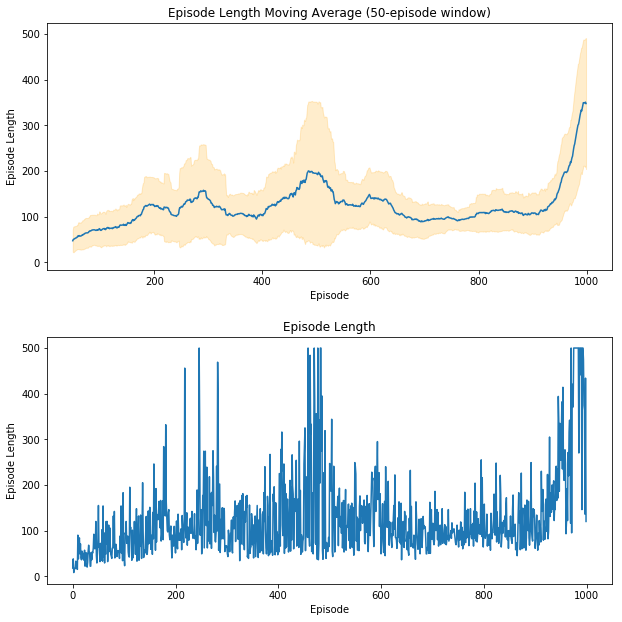

In [7]:
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')